# 3. Convolutional Neural Networks (60 pts)

### Implement the convolutional neural network shown below and train it on cats-dogs dataset uploaded to ODTUClass

__- Use your own implementation.__

__- Try to explain what you did for each cell you fill in.__



## Imports

In [1]:
import torch, torchvision
import numpy as np
import matplotlib.pyplot as plt

# Helper for visualization
def torch_imshow(img):
    img = img.permute(1,2,0)
    plt.imshow(img.cpu().numpy())
    plt.show()

# Prepare Datasets
In this part, you are going to use cats-dogs dataset uploaded to ODTUClass.

To convert 'cat and dog photos in class-separated directories' to PyTorch dataset; `ImageFolder` utility of torchvision is used.


In [2]:
## Note: If you are using Google Colab, upload the uncompressed dataset
# to your Google Drive and uncomment the lines below to mount your Google Drive here.

#from google.colab import drive
#drive.mount("/content/gdrive")

# After mounting the drive, your Google Drive contents
# will be in path: "/content/gdrive/MyDrive/"
# You can use the shell commands like "ls, cd" to navigate and peek into directories.
# Shell commands are used with "!" in the notebook.
### e.g: !ls '/content/gdrive'


In [3]:
import os

#enter the path to "cats_dogs" directory
dataset_path = '/home/cagnur/Desktop/DL/A2/Assignment2/cats_dogs/'


training_set_path = os.path.join(dataset_path, 'training_set')
validation_set_path = os.path.join(dataset_path, 'validation_set')
test_set_path = os.path.join(dataset_path, 'test_set')

print(training_set_path)
print(validation_set_path)
print(test_set_path)

/home/cagnur/Desktop/DL/A2/Assignment2/cats_dogs/training_set
/home/cagnur/Desktop/DL/A2/Assignment2/cats_dogs/validation_set
/home/cagnur/Desktop/DL/A2/Assignment2/cats_dogs/test_set


## a) Prepare Training Dataset


In [4]:
#------------- (Training dataset transforms)---------------------------------#
# 1) Use random horizontal flip with probability 0.5 as data augmentation
# 2) Resize image to 100 x 100
# 3) Convert image to torch tensor.
#----------------------------------------------------------------------------#



training_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(p=0.5), # CT: For Data augmentation purposes
    torchvision.transforms.Resize((100,100)), # CT: Standardize the input / Data pre-processing
    torchvision.transforms.ToTensor() # CT: Standardize the input / Data pre-processing
])

training_dataset = torchvision.datasets.ImageFolder(root=training_set_path, 
                                                    transform=training_transforms)




## b) Prepare Validation Dataset


In [5]:
#------------- (Validation dataset transforms)--------------------------------#
# 1) Resize image to 100 x 100
# 2) Convert image to torch tensor.
#----------------------------------------------------------------------------#

validation_transforms = torchvision.transforms.Compose([ # CT: We can apply data augmentation. However, the main goal is training the model so we dont need to apply for validation and test dataset
    torchvision.transforms.Resize((100,100)), # CT: Standardize the input / Data pre-processing
    torchvision.transforms.ToTensor() # CT: Standardize the input / Data pre-processing
])

validation_dataset = torchvision.datasets.ImageFolder(root=validation_set_path, 
                                                      transform=validation_transforms)




## c) Prepare Test Dataset


In [6]:
#------------- (Test dataset transforms)-------------------------------------#
# 1) Resize image to 100 x 100
# 2) Convert image to torch tensor.
#----------------------------------------------------------------------------#


test_transforms = torchvision.transforms.Compose([ # CT: We can apply data augmentation. However, the main goal is training the model so we dont need to apply for validation and test dataset
    torchvision.transforms.Resize((100,100)),  # CT: Standardize the input / Data pre-processing
    torchvision.transforms.ToTensor() # CT: Standardize the input / Data pre-processing
])

test_dataset = torchvision.datasets.ImageFolder(root=test_set_path, 
                                                    transform=test_transforms)


## d) Visualize 1 data sample for each class in training set


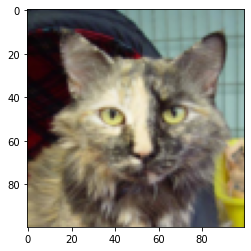

Label for cat: 0


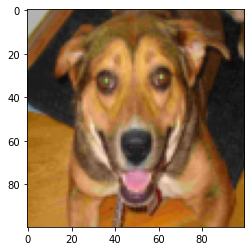

Label for dog: 1


In [7]:
cat_img, cat_label = training_dataset[1]
torch_imshow(cat_img)
print(f'Label for cat: {cat_label}')

dog_img, dog_label = training_dataset[-1]
torch_imshow(dog_img)
print(f'Label for dog: {dog_label}')

# Prepare Dataloaders


In [8]:
#-------------------------------------------------------------------------------------------------------------#
# -- Use batch size of 32 for all datasets
# -- Shuffle data only for training dataset
#-------------------------------------------------------------------------------------------------------------#
#
#
# CT: Dataloader Class provides GPU-friendly framework for the model. Although we don't use in here, it has another parameter num_workers provides multi-process data loading.
training_dataloader   = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=False)
test_dataloader       = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)



# Create network


<img src="https://i.ibb.co/pXb6gHY/model.png" height="400" width="1000">

In [9]:
# Define and initialize the model in the figure above
# -- Use stride = 1 for convolutional layers
# -- Use stride = 3 for max pooling layers
# -- Use 'relu' activation for hidden layers
# -- Use batch normalization after all convolutional layers
# -- Use dropout with 0.1 probability for the hidden fully connected layer
# -- You are free to use softmax, log-softmax or no activation in the final layer
# -- However, you are going to need to choose a loss function accordingly.

#-------------------------------------------------------------------------------------------------------------#
import torch.nn.functional as F
class ConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__() #don't remove this line
        self.layers = torch.nn.Sequential(
            # CT: In the picture above:
            # -the kernel Size for Conv2d is (5,5)
            # -the kernel size for MaxPool2d is (3,3)
            # So we add these parameters in addition to given parameters in guideline.
            torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(5,5), stride=1), # CT: 96x96x16
            torch.nn.MaxPool2d(kernel_size=(3,3), stride=3), # CT: 32x32x16
            torch.nn.BatchNorm2d(num_features=16),# CT: It brings all the weight in the same scale to prevent vanishing/exploiding gradient
            torch.nn.ReLU(),        
            #layer2
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5,5), stride=1), # CT: 28x28x32
            torch.nn.MaxPool2d(kernel_size=(3,3), stride=3), #
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.Dropout2d(p=0.1), # CT: In training process, it prevents overfiting. How? Randomly zeros some of the elements. P is the prob of the zero-element
            torch.nn.ReLU(),
            #layer3
            torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(5,5), stride=1), # CT:5x5x32
            torch.nn.MaxPool2d(kernel_size=(3,3), stride=3), # CT: 1x1x32
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.Flatten(),
            torch.nn.Linear(32,16),
            torch.nn.Linear(16,2),
            #torch.nn.LogSoftmax(dim=1) # CT: Loss function handle this layer.
            
        )

        
    def forward(self, x):
        return self.layers(x)
    
    
    
test_convnet = ConvNet().to('cuda')
test_input = torch.randn(32, 3, 100, 100, device='cuda')
test_output = test_convnet(test_input)
print(test_output.shape)

torch.Size([32, 2])


# Define loss function


In [10]:
# Define loss function to use here
#-------------------------------------------------------------------------------------------------------------#
# -- Note: Take the final activation of your neural network into account
#-------------------------------------------------------------------------------------------------------------#
#
loss_fn = torch.nn.CrossEntropyLoss() # CT: It is the combination of nn.LogSoftmax +nn.NLLLoss.

# Define optimizer


In [11]:
# Define optimizer here
#-------------------------------------------------------------------------------------------------------------#
# -- Use Adam optimizer with default hyperparameters
#-------------------------------------------------------------------------------------------------------------#
#
optimizer = torch.optim. Adam(test_convnet.parameters()) # CT: Implements Adam Alg

# Define validation(test) loop

In [12]:
# Define a function that takes a model and a dataloader and outputs model accuracy on the dataloader
# This function is to be used on both validation and test dataloader.
#-------------------------------------------------------------------------------------------------------------#
# -- Note: Don't forget to toggle eval mode on at the beginning of the function and toggle it off at the end.
# -- Note: When testing for accuracies, torch doesn't need to keep track of activations and gradients in the network. 
#      You may want to turn off gradients for test loop.
#-------------------------------------------------------------------------------------------------------------#
def check_accuracy(neuralnet, dataloader):
    
    ## Toggle eval mode on
    ##   https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch
    
    neuralnet.eval() 
    # CT: During training process, we apply some tricks to train the model better. For example: Batch Normalization and Dropout.
    # After training process, we do not need to apply these processes and we can just use the weights to test the model.
    # In order to not apply these processes in the test and valid time, this "eval()" function behaves as a switch
    
    
    
    num_correct_predictions   = 0
    num_incorrect_predictions = 0
    
    for imgs_batch, labels_batch in dataloader:
        
        # Load batches to GPU
        imgs_batch, labels_batch = imgs_batch.to("cuda"), labels_batch.to("cuda")
        
        # Pass input images to the network
        # Obtain predictions from network output
        # Name the variable that holds predictions as `predictions_batch`
        # 'predictions_batch' needs to hold class predictions as 0 (cat) and 1 (dog) 
        
        with torch.no_grad():
            predictions_batch=neuralnet(imgs_batch).argmax(dim=1)       
        
        
        
        
        num_correct_predictions_batch   = torch.sum(predictions_batch == labels_batch)
        num_incorrect_predictions_batch = torch.sum(predictions_batch != labels_batch)
        
        num_correct_predictions   += num_correct_predictions_batch.item()
        num_incorrect_predictions += num_incorrect_predictions_batch.item()
    
    accuracy = num_correct_predictions / (num_correct_predictions + num_incorrect_predictions)
    
    
    ## Toggle eval mode off to turn back to training mode
    neuralnet.eval()
    
    return accuracy    
    

## Test performance before training

In [13]:
# Use the test function you defined above to test your network on test set before training
# Untrained network accuracy should be around 50%

test_accuracy = check_accuracy(test_convnet, test_dataloader)
print(f'Test accuracy before training: {test_accuracy * 100 :.2f}%')

Test accuracy before training: 50.00%


## Define training loop


In [14]:
# Define a function that takes a model, a dataloader, an optimizer and a loss function and trains the model
#  on the dataloader for 1 epoch using optimizer and loss function. This function is not supposed to return anything.
#-------------------------------------------------------------------------------------------------------------#

def train_one_epoch(neuralnet, dataloader, optimizer, loss_fn):
    
    for imgs_batch, labels_batch in dataloader:
        imgs_batch, labels_batch = imgs_batch.to("cuda"), labels_batch.to("cuda")
        
        
        optimizer.zero_grad() # CT: Before starting the backpropogation we should set graident to zero. WHY? Because pytorch accumulates the gradient. (Ref: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        predictions_batch=neuralnet(imgs_batch) ## Pass inputs to the network
        loss = loss_fn(predictions_batch, labels_batch) ## Calculate loss using labels and network outputs
        loss.backward() ## Take a step with optimizer (don't forget `zero_grad` and `backward`!)
        optimizer.step()

        
        
        

## Train
Train the network for at least 10 epochs. Measure both training and validation accuracy after each epoch, show it on a epoch/accuracy graph.


In [15]:
# Use the training function you defined above to train your network on training set.

training_accuracy_list = []
validation_accuracy_list = []

NUM_EPOCHS = 30 #at least 10

for epoch_no in range(NUM_EPOCHS):
    print(f'Epoch {epoch_no + 1}...')
    
    train_one_epoch(test_convnet, training_dataloader, optimizer, loss_fn)
    
    training_accuracy = check_accuracy(test_convnet, training_dataloader)
    print(f'Training   accuracy: {training_accuracy * 100 :.2f}%')
    validation_accuracy = check_accuracy(test_convnet, validation_dataloader)
    print(f'Validation accuracy: {validation_accuracy * 100 :.2f}%')
    
    training_accuracy_list.append(training_accuracy)
    validation_accuracy_list.append(validation_accuracy)  



Epoch 1...
Training   accuracy: 50.00%
Validation accuracy: 50.00%
Epoch 2...
Training   accuracy: 57.63%
Validation accuracy: 55.00%
Epoch 3...
Training   accuracy: 61.12%
Validation accuracy: 56.75%
Epoch 4...
Training   accuracy: 58.81%
Validation accuracy: 56.25%
Epoch 5...
Training   accuracy: 63.06%
Validation accuracy: 56.50%
Epoch 6...
Training   accuracy: 62.62%
Validation accuracy: 55.75%
Epoch 7...
Training   accuracy: 66.88%
Validation accuracy: 60.75%
Epoch 8...
Training   accuracy: 67.38%
Validation accuracy: 62.50%
Epoch 9...
Training   accuracy: 64.56%
Validation accuracy: 57.25%
Epoch 10...
Training   accuracy: 70.56%
Validation accuracy: 63.00%
Epoch 11...
Training   accuracy: 68.88%
Validation accuracy: 64.25%
Epoch 12...
Training   accuracy: 73.88%
Validation accuracy: 64.50%
Epoch 13...
Training   accuracy: 74.00%
Validation accuracy: 67.00%
Epoch 14...
Training   accuracy: 74.38%
Validation accuracy: 66.25%
Epoch 15...
Training   accuracy: 77.50%
Validation accura

## Plot

Text(0, 0.5, 'Accuracy')

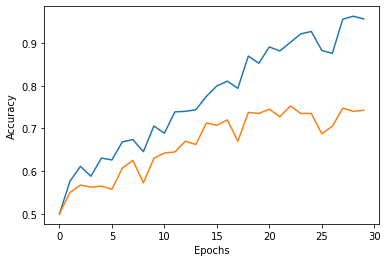

In [16]:
plt.plot(training_accuracy_list)
plt.plot(validation_accuracy_list)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

## Test
Test the network on the test set


In [17]:
# Use the test function you defined above to test your network before training
test_accuracy = check_accuracy(test_convnet, test_dataloader)
print(f'Test accuracy after training: {test_accuracy * 100 :.2f}%')

Test accuracy after training: 74.00%


## Save (optional)
If you managed to reach 70%+ accuracy in the test set, save the trained network to use in bonus (4th) question.


In [18]:
# https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [19]:
# If you are using Google Colab, check this article
# https://medium.com/@ml_kid/how-to-save-our-model-to-google-drive-and-reuse-it-2c1028058cb2

In [26]:
torch.save(test_convnet, '/home/cagnur/Desktop/DL/A2/Assignment2/Q3.pt')